## Projeção Perspectiva

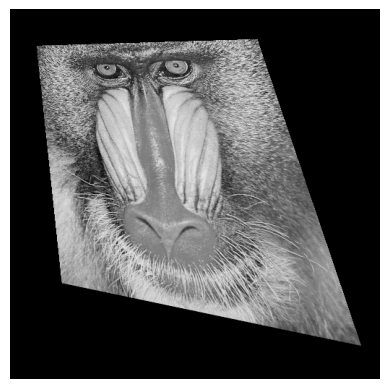

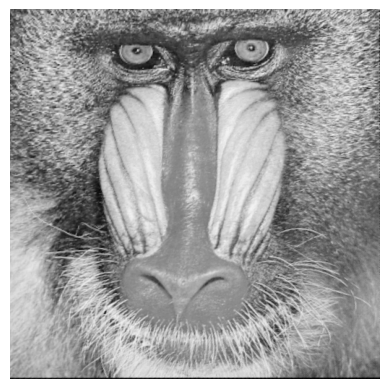

In [10]:
from pathlib import Path
import numpy as np
import skimage.io as io
from skimage.transform import ProjectiveTransform
from skimage import transform
from matplotlib import pyplot as plt

# Path to the images
images_path = Path('images')

# Read the images
image = io.imread(images_path / 'baboon_perspectiva.png')

image = image[:,:,0]

# Define os pontos de origem e destino
src = np.array([[0, 0], [511, 0], [511, 511], [0, 511]])
dst = np.array([[37, 51], [342, 42], [485, 467], [73, 380]])

# Cria a transformação perspectiva
tform = ProjectiveTransform()
tform.estimate(src, dst)

image_transformed = transform.warp(image, tform)

# Exibe a imagem resultante
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()
plt.imshow(image_transformed, cmap='gray')
plt.axis('off')
plt.show()

In [27]:
def warp(image: np.ndarray, transform: np.ndarray) -> np.ndarray:
    """Apply a transformation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Image to be transformed.
    transform : np.ndarray
        Transformation matrix.
    
    Returns
    ----------
    np.ndarray
        Transformed image.
    """

    t_image = np.zeros_like(image)

    # t_image(x, y) = transform * image(x, y)
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            # Get the coordinates of the transformed pixel
            x_t, y_t, _ = np.dot(transform, np.array([x, y, 1]))
            # Get the pixel value
            t_image[x, y] = image[int(x_t), int(y_t)]
    
    return t_image

In [68]:
def apply_geometric_transform(image, transformation_matrix):
    # Obtém as dimensões da imagem
    rows, cols = image.shape

    # Cria uma matriz com as coordenadas dos pixels da imagem
    coords = np.indices((rows, cols), dtype=np.float32)
    coords = np.vstack((coords[0].ravel(), coords[1].ravel(), np.ones(rows*cols)))


    # Aplica a transformação na matriz de coordenadas
    coords_transformed = np.dot(transformation_matrix, coords)

    coords = coords.astype(np.int32)

    # Converte as coordenadas transformadas em inteiros
    coords_transformed = np.round(coords_transformed[:2] / coords_transformed[2]).astype(np.int32)

    # Verifica se as coordenadas transformadas estão dentro dos limites da imagem
    mask = (
        (coords_transformed[0] >= 0) & (coords_transformed[0] < rows) &
        (coords_transformed[1] >= 0) & (coords_transformed[1] < cols)
    )

    image_transformed = np.zeros_like(image)
    # coords_transformed[0], coords_transformed[1]
    # Cria a imagem transformada
    image_transformed[coords[0], coords[1]] = (
        image[coords_transformed[0], coords_transformed[1]]
    )

    return image_transformed

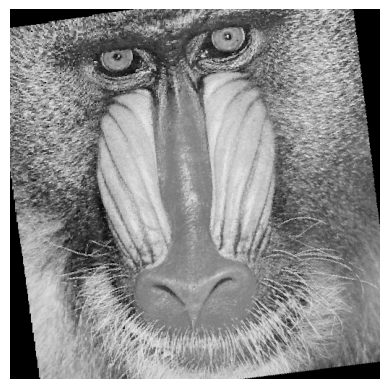

In [69]:
from pathlib import Path
import skimage.io as io
from numpy.linalg import solve
from matplotlib import pyplot as plt

# Path to the images
images_path = Path('images')

# Read the images
image = io.imread(images_path / 'baboon_perspectiva.png')
image = image[:,:,0]

# Define os pontos de origem e destino
src = np.array([[0, 0], [511, 0], [511, 511], [0, 511]])
dst = np.array([[37, 51], [342, 42], [485, 467], [73, 380]])

# Cria a matriz de coeficientes do sistema de equações
A = np.zeros((8, 8))
for i in range(4):
    A[i*2,:] = [src[i,0], src[i,1], 1, 0, 0, 0, -dst[i,0]*src[i,0], -dst[i,0]*src[i,1]]
    A[i*2+1,:] = [0, 0, 0, src[i,0], src[i,1], 1, -dst[i,1]*src[i,0], -dst[i,1]*src[i,1]]

# Cria o vetor de soluções do sistema de equações
b = np.zeros((8,))
for i in range(4):
    b[i*2] = dst[i,0]
    b[i*2+1] = dst[i,1]

# Resolve o sistema de equações
h = solve(A, b)

# Cria a matriz de projeção perspectiva
H = np.zeros((3,3))
H[0,:] = h[:3]
H[1,:] = h[3:6]
H[2,:2] = h[6:]
H[2,2] = 1


# Aplica a transformação na imagem
# image_transformed_1 = transform.warp(image, H)
# # Exibe a imagem resultante
# plt.imshow(image_transformed_1, cmap='gray')
# plt.axis('off')
# plt.show()

# image_transformed_2 = warp(image, H)
# plt.imshow(image_transformed_2, cmap='gray')
# plt.axis('off')
# plt.show()

image_transformed_3 = apply_geometric_transform(image, H)
plt.imshow(image_transformed_3, cmap='gray')
plt.axis('off')
plt.show()

## 2 Transformações Geométricas

### Bibliotecas

In [73]:
from pathlib import Path
import numpy as np
from skimage import transform, io
from matplotlib import pyplot as plt

### Funções Auxiliares

In [74]:
def open_image(image_path:Path) -> np.ndarray:
    """Abre uma imagem binária e retorna uma matriz numpy.
    Parâmetros:
        image_path: caminho para a imagem
    Retorno:
        Imagem como uma matriz numpy.
    """
    image = io.imread(image_path)
    assert len(image.shape) == 2, f"A Imagem {image_path.name} tem mais de 1 canal"
    # returns a binary version of the image
    return image

def two_images(original:np.ndarray, processed:np.ndarray, t1:str, t2:str, path:Path=None):
    """Visualizar a imagem original versus o resultado do processamento.
    Parâmetros:
        original: imagem original
        processed: imagem processada
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 8))
    fig.tight_layout(pad=0.5)

    axs[0].imshow(original, cmap="gray")
    axs[1].imshow(processed, cmap="gray")

    axs[0].set_title(f"(a) {t1}")
    axs[1].set_title(f"(b) {t2}")

    axs[0].axis("off")
    axs[1].axis("off")
    plt.show()

    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)

def histogram(img:np.ndarray, bins:int=256) -> np.ndarray:
    """Calcula o histograma de uma imagem.
    Parâmetros:
        img: imagem
        bins: número de bins
    """
    return np.histogram(img, bins=bins)[0]

def black_percentual(histogram:np.ndarray) -> float:
    """Calcula o percentual de pixels pretos em uma imagem.
    Parâmetros:
        histogram: histograma da imagem
    Retorno:
        Percentual de pixels pretos.
    """
    return np.round(histogram[0] / histogram.sum(), 4) * 100

def img_and_histogram(img:np.ndarray, hist:np.ndarray, title:str, path:Path=None):
    """Visualizar a imagem e seu histograma.
    Parâmetros:
        img: imagem
        hist: histograma
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), gridspec_kw={'width_ratios': [3, 1]})
    plt.suptitle(title)
    
    # Image
    axs[0].set_title("(a) Imagem")
    axs[0].imshow(img, cmap="gray")
    axs[0].axis("off")

    # Histogram
    axs[1].set_title("(b) Histograma")
    bins_range = range(hist.shape[0])
    if hist.shape[0] == 2:
        percents = [black_percentual(hist), 100 - black_percentual(hist)]
        bar = axs[1].bar(bins_range, percents, width=1, align='center', edgecolor='black', color="#006AF4")
        axs[1].set_xticks([0, 1], ["preto", "branco"])
        axs[1].axes.yaxis.set_visible(False)
        axs[1].spines['right'].set_visible(False)
        axs[1].spines['top'].set_visible(False)
        axs[1].spines['left'].set_visible(False)
        black_per =  f"{percents[0]:.2f}%"
        axs[1].text(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height(), black_per, ha='center', va='bottom', fontsize=12)
        white_per =  f"{percents[1]:.2f}%"
        axs[1].text(bar[1].get_x() + bar[1].get_width() / 2, bar[1].get_height(), white_per, ha='center', va='bottom', fontsize=12)
    else:
        axs[1].bar(bins_range, hist, color="#006AF4")
        text =  f"preto: {black_percentual(hist):.2f}%"
        axs[1].text(0.2, 0.9, text, transform=axs[1].transAxes, color="black", fontsize=14)

    plt.show()

    # Save figure
    if path:
        fig.savefig(path, bbox_inches='tight', pad_inches=0.1)

def image_properties(image:np.ndarray):
    """Imprime as propriedades da imagem.
    Parâmetros:
        image: imagem
    """
    print("Propriedades da imagem:")
    print(f"Dimensões: {image.shape}")
    print(f"Tipo de dados: {image.dtype}")
    print(f"Mínimo: {image.min()}")
    print(f"Máximo: {image.max()}")

### Abrir a imagem original

In [75]:
images_path = Path('images')
image = open_image(images_path / 'baboon.png')
image_properties(image)

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: uint8
Mínimo: 0
Máximo: 230


### Transformações Geométricas

#### Rotação

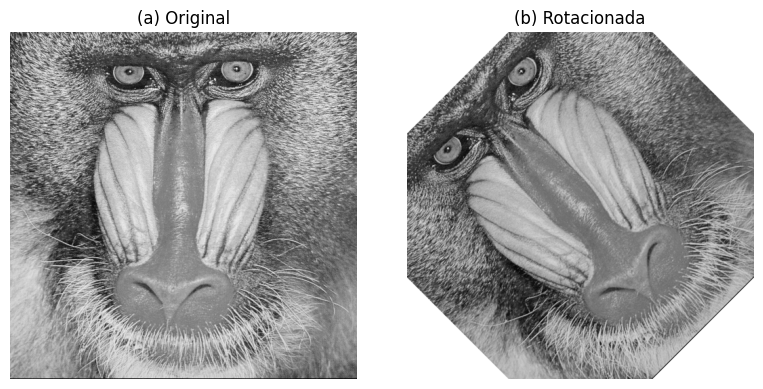

Propriedades da imagem:
Dimensões: (512, 512)
Tipo de dados: float64
Mínimo: 0.013605210779915253
Máximo: 1.0


In [76]:
# Definir angulo de rotação
angle = 45
# Definir o centro de rotação
center = (0, 0)
center = None
mode = ['constant', 'edge', 'symmetric', 'reflect', 'wrap']
# Rotacionar a imagem
image_rotated = transform.rotate(
    image, angle, resize=False, center=center, order=3, mode='constant', cval=1
)

# Visualizar a imagem original e a rotacionada
two_images(image, image_rotated, "Original", "Rotacionada")

# propriedades da imagem rotacionada
image_properties(image_rotated)

#### Escala (Fator de escala)

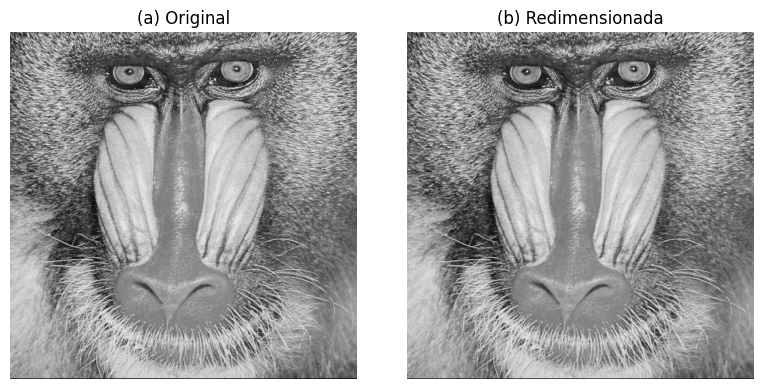

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [78]:
# Definir o fator de escala
scale = 2

# Redimensionar a imagem
image_resized = transform.rescale(
    image, scale, order=3, anti_aliasing=False, mode='constant', cval=1
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, "Original", "Redimensionada")

# propriedades da imagem redimensionada
image_properties(image_resized)

#### Escala (Altura, Largura)

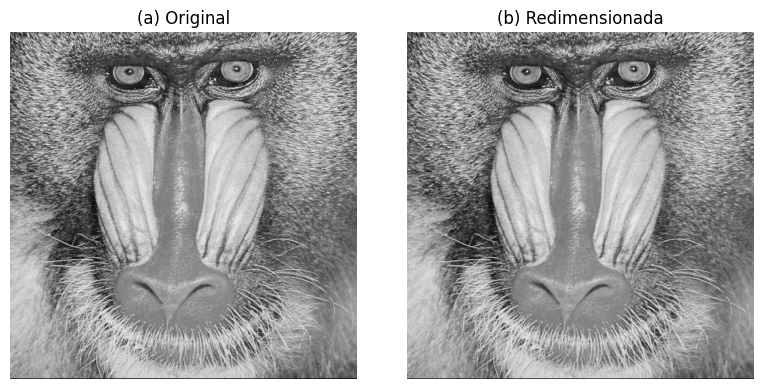

Propriedades da imagem:
Dimensões: (1024, 1024)
Tipo de dados: float64
Mínimo: 0.0
Máximo: 0.9019607843137255


In [84]:
# Definir altura e largura
height, width = 1024, 1024

# Redimensionar a imagem
image_resized = transform.resize(
    image, (height, width), order=3, anti_aliasing=False, mode='constant', cval=1
)

# Visualizar a imagem original e a redimensionada
two_images(image, image_resized, "Original", "Redimensionada")

# propriedades da imagem redimensionada
image_properties(image_resized)